In [1]:
# Import libraries
import numpy as np
import pandas as pd
from obspy import read
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os

from sklearn.preprocessing import MinMaxScaler

from obspy.signal.invsim import cosine_taper
from obspy.signal.filter import highpass
from obspy.signal.trigger import classic_sta_lta, plot_trigger, trigger_onset

import numpy as np
from scipy.fft import fft, ifft, fftfreq

In [2]:
cat_directory = './data/lunar/training/catalogs/'
cat_file = cat_directory + 'apollo12_catalog_GradeA_final.csv'
cat = pd.read_csv(cat_file)

In [ ]:
#index = np.arange(0, 35, 1)
for i in range(1):    
    i=27
    row = cat.iloc[i]
    arrival_time = datetime.strptime(row['time_abs(%Y-%m-%dT%H:%M:%S.%f)'],'%Y-%m-%dT%H:%M:%S.%f')
    #print(arrival_time)

    #print(row)

    # If we want the value of relative time, we don't need to use datetime
    arrival_time_rel = row['time_rel(sec)']
    #print(arrival_time_rel)

    # Let's also get the name of the file
    test_filename = row.filename
    #print(test_filename)

    data_directory = './data/lunar/training/data/S12_GradeA/'
    mseed_file = f'{data_directory}{test_filename}.mseed'
    st = read(mseed_file)
    #print(st)
    # The stream file also contains some useful header information
    #print(st[0].stats)

    # This is how you get the data and the time, which is in seconds
    tr = st.traces[0].copy()
    tr_times = tr.times()
    tr_data = tr.data

    # Start time of trace (another way to get the relative arrival time using datetime)
    starttime = tr.stats.starttime.datetime
    arrival = (arrival_time - starttime).total_seconds()
    #print(arrival)


    print(np.shape(tr_times))
    print(np.shape(tr_data))

    print(arrival_time_rel)


    fig,ax = plt.subplots(1,1,figsize=(10,3))

    # Plot trace
    ax.plot(tr_times,tr_data)

    # Mark detection
    ax.axvline(x = arrival, color='red',label='Rel. Arrival')
    ax.legend(loc='upper left')

    # Make the plot pretty
    ax.set_xlim([min(tr_times),max(tr_times)])
    #ax.set_xlim([51000,57000])
    ax.set_ylabel('Velocity (m/s)')
    ax.set_xlabel('Time (s)')
    ax.set_title(f'{test_filename} -- {i}', fontweight='bold')

    ### FILTEERR

    # Set the minimum frequency
    # minfreq = 0.5
    # maxfreq = 1.0
    minfreq = 0.5
    maxfreq = 1.0

    # Going to create a separate trace for the filter data
    st_filt = st.copy()
    st_filt.filter('bandpass',freqmin=minfreq,freqmax=maxfreq)
    tr_filt = st_filt.traces[0].copy()
    tr_times_filt = tr_filt.times()
    tr_data_filt = tr_filt.data

    # Plot the time series and spectrogram
    fig = plt.figure(figsize=(10, 10))
    ax = plt.subplot(2, 1, 1)
    # Plot trace
    ax.plot(tr_times_filt,tr_data_filt)

    # Mark detection
    ax.axvline(x = arrival, color='red',label='Detection')
    ax.legend(loc='upper left')

    # Make the plot pretty
    ax.set_xlim([min(tr_times_filt),max(tr_times_filt)])
    ax.set_ylabel('Velocity (m/s)')
    ax.set_xlabel('Time (s)')

    ### Normalizacion de las Velocidades

    # Normalize [-1, 1]
    # Reshape array to use MinMaxScaler
    
    tr_data_filt_norm = tr_data_filt.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(-1, 1))
    tr_data_filt_norm = scaler.fit_transform(tr_data_filt_norm)

    # Initialize figure
    fig,ax = plt.subplots(1,1,figsize=(10,3))

    # Plot trace
    ax.plot(tr_times,tr_data_filt_norm)

    # Mark detection
    ax.axvline(x = arrival, color='red',label='Rel. Arrival')
    ax.legend(loc='upper left')

    # Make the plot pretty
    ax.set_xlim([min(tr_times),max(tr_times)])
    #ax.set_xlim([51000,57000])
    ax.set_ylabel('Velocity (m/s)')
    ax.set_xlabel('Time (s)')
    ax.set_title(f'{test_filename}', fontweight='bold')


In [3]:
from obspy.signal.invsim import cosine_taper
from obspy.signal.filter import highpass
from obspy.signal.trigger import classic_sta_lta, plot_trigger, trigger_onset

In [4]:
def data_extrac(N=27, data_directory = './data/lunar/training/data/S12_GradeA/'):
    '''
    Extrae los datos de un archivo N del catalogo y filtra por bandpass
    ademas mas cositas (proximamente)
    '''

    #Obtener le ubicacion de los datos de una señal
    row = cat.iloc[N]          #señal N (27)

    test_filename = row.filename
    arrival_time_rel = row['time_rel(sec)']

    #Obtener datos de la señal
    mseed_file = f'{data_directory}{test_filename}.mseed'
    st = read(mseed_file)       #stream file (contains the trace(s))

    tr = st.traces[0].copy()    #Datos de la señal
    tr_times = tr.times()       #en segundos
    tr_data = tr.data

    #Filtro de band pass para frecuencias
    st_filt = st.copy()
    st_filt.filter('bandpass',freqmin=0.5,freqmax=1.0)
    tr_filt = st_filt.traces[0].copy()
    df = tr_filt.stats.sampling_rate
    tr_times_filt = tr_filt.times()
    tr_data_filt = tr_filt.data

    #Filtro de normalizacion de velocidades
    tr_data_filt_norm = tr_data_filt.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(-1, 1))
    tr_data_filt_norm = scaler.fit_transform(tr_data_filt_norm)

    starttime = tr.stats.starttime.datetime
    arrival_time = datetime.strptime(row['time_abs(%Y-%m-%dT%H:%M:%S.%f)'],'%Y-%m-%dT%H:%M:%S.%f')
    arrival = (arrival_time - starttime).total_seconds()

    return tr_times, tr_data_filt_norm, arrival, df

tr_times, tr_data_filt_norm, arrival_time_rel, df= data_extrac(30)

In [27]:
def data_extrac_test(N=1, data_directory = './data/lunar/test/data/S12_GradeB'):
    '''
    Extrae los datos de un archivo N del catalogo y filtra por bandpass
    ademas mas cositas (proximamente)
    '''
    # Lista para almacenar los nombres de los archivos
    path_data = []

    # Recorrer todos los archivos en el directorio
    for nombre_archivo in os.listdir(data_directory):
        # Comprobar si es un archivo (y no una carpeta)
        if os.path.isfile(os.path.join(data_directory, nombre_archivo)) and nombre_archivo.endswith('.mseed'):
            path_data.append(nombre_archivo)

    #Obtener datos de la señal
    mseed_file = data_directory+'/'+path_data[N]
    st = read(mseed_file)       #stream file (contains the trace(s))

    tr = st.traces[0].copy()    #Datos de la señal
    tr_times = tr.times()       #en segundos
    tr_data = tr.data

    #Filtro de band pass para frecuencias
    st_filt = st.copy()
    st_filt.filter('bandpass',freqmin=0.5,freqmax=1.0)
    tr_filt = st_filt.traces[0].copy()
    df = tr_filt.stats.sampling_rate
    tr_times_filt = tr_filt.times()
    tr_data_filt = tr_filt.data

    #Filtro de normalizacion de velocidades
    tr_data_filt_norm = tr_data_filt.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(-1, 1))
    tr_data_filt_norm = scaler.fit_transform(tr_data_filt_norm)

    return tr_times, tr_data_filt_norm, df, tr_data

tr_times, tr_data_filt_norm, df, raw_data= data_extrac_test(54)



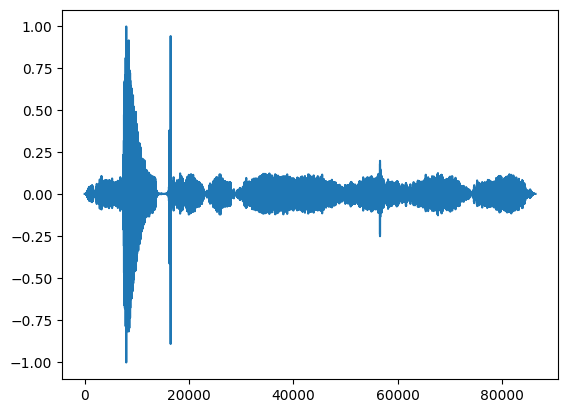

In [28]:
plt.plot(tr_times,tr_data_filt_norm)

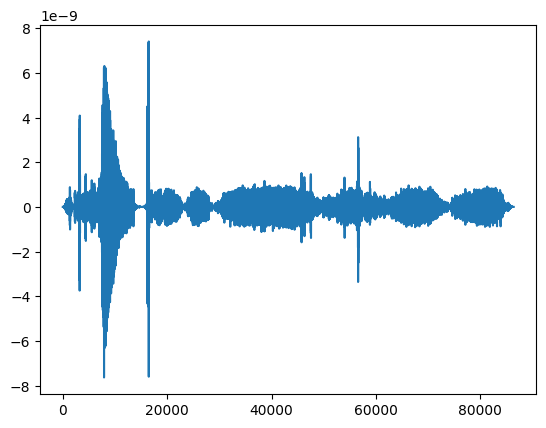

In [29]:
plt.plot(tr_times,raw_data)

Text(0, 0.5, 'Characteristic function')

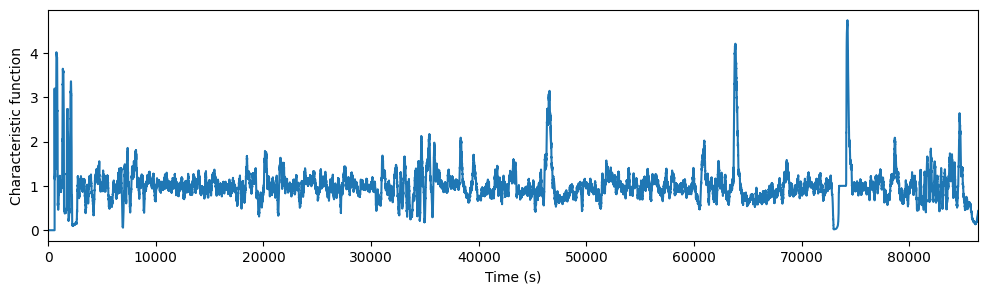

In [22]:

def CFT(tr_data_filt_norm, df):

    #STA/LTA
    # How long should the short-term and long-term window be, in seconds?\
    sta_len = 120       #120
    lta_len = 600       #600
    # sta_len = 1000
    # lta_len = 2000

    # Run Obspy's STA/LTA to obtain a characteristic function
    # This function basically calculates the ratio of amplitude between the short-term 
    # and long-term windows, moving consecutively in time across the data
    #cft = classic_sta_lta(tr_data, int(sta_len * df), int(lta_len * df))
    tr_data_filt_norm = tr_data_filt_norm.reshape(-1)
    cft = classic_sta_lta(tr_data_filt_norm, int(sta_len * df), int(lta_len * df))
    return cft

cft = CFT(tr_data_filt_norm, df)
# Plot characteristic function
fig,ax = plt.subplots(1,1,figsize=(12,3))
ax.plot(tr_times,cft)
ax.set_xlim([min(tr_times),max(tr_times)])
#ax.set_xlim([72000,76000])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Characteristic function')

In [7]:
import numpy as np
from scipy.fft import fft, ifft, fftfreq

Text(0, 0.5, 'Characteristic function')

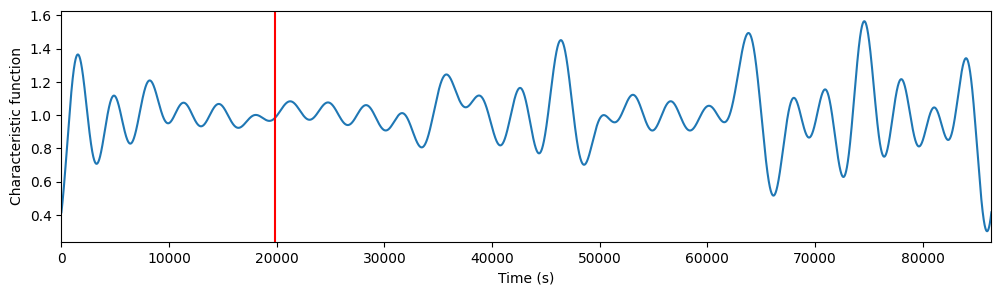

In [23]:
def test(cft):
    # Número de puntos en el arreglo
    n = len(cft)

    # Frecuencia de muestreo (puedes ajustarla dependiendo del contexto)
    sampling_rate = 1 #df  # Ajusta según corresponda

    # Realizar la FFT del arreglo
    cft_fft = fft(cft)

    # Crear las frecuencias correspondientes
    frequencies = fftfreq(n, d=sampling_rate)

    # Definir la frecuencia de corte para el filtro
    cutoff_freq = 0.0001/2 # Ajusta según lo que necesites

    # Aplicar el filtro pasa bajos: eliminar las frecuencias más altas que la frecuencia de corte
    cft_fft[np.abs(frequencies) > cutoff_freq] = 0

    # Realizar la inversa de la FFT para regresar al dominio temporal
    filtered_cft = ifft(cft_fft)

    # La señal filtrada está en dominio temporal (real)
    filtered_cft_real = np.real(filtered_cft)

    #print("Arreglo original:", cft)
    #print("Arreglo filtrado:", filtered_cft_real)
    return filtered_cft_real

filtered_cft_real = test(cft)
# Plot characteristic function
fig,ax = plt.subplots(1,1,figsize=(12,3))
ax.plot(tr_times,filtered_cft_real)
ax.set_xlim([min(tr_times),max(tr_times)])
ax.axvline(x = arrival_time_rel, color='red',label='Rel. Arrival')
#ax.set_xlim([72000,76000])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Characteristic function')



Error relativo:  [0.55978981]


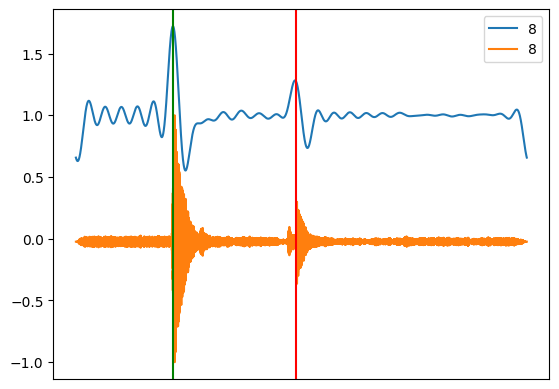

Error relativo:  [0.21899371]


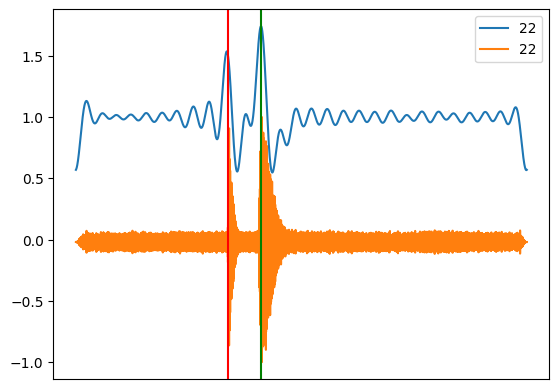

Error relativo:  [1.37362001]


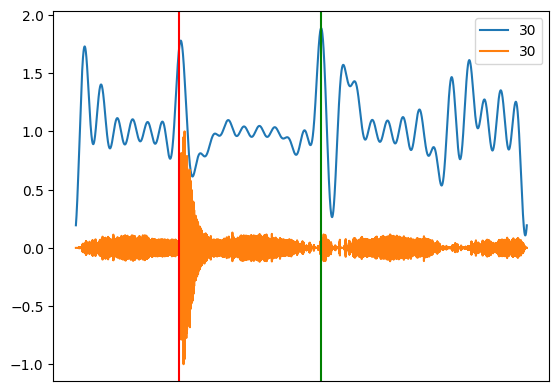

Error relativo:  [1.81837782]


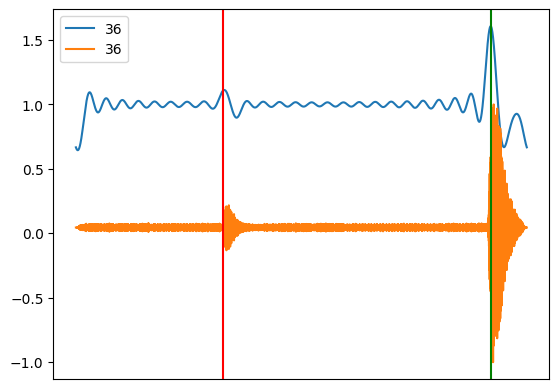

Error relativo:  [0.7550268]


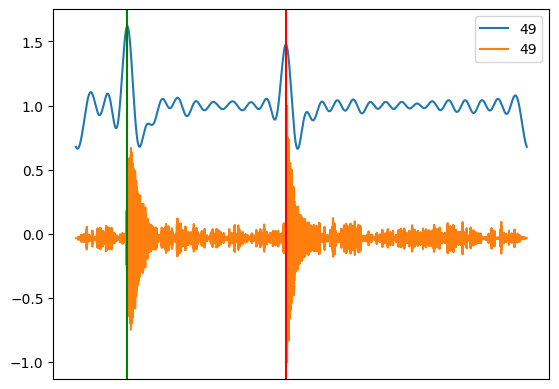

Error relativo:  [0.78714662]


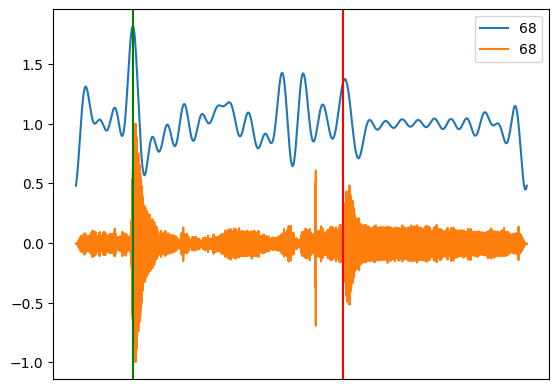

Cantidad de nuevos sospechosos OJO PAPA: 6


In [50]:
#main loop papa
total = 75
tol = .20
sospechoso=0
#coins = np.random.randint(0,75, 9)
#fig,ax = plt.subplots(total,1,figsize=(16,12))
for i in range(total):
    tr_times, tr_data_filt_norm, arrival_time_rel , df= data_extrac(i)
    cft = CFT(tr_data_filt_norm, df)
    filter_cft = test(cft)
    max_pos = tr_times[np.where(filter_cft==filter_cft.max())]
    max_pos2 = tr_times[np.where(filter_cft==filter_cft.max())]
    
    error_relativo = np.abs((arrival_time_rel-max_pos)/arrival_time_rel)
    
    if error_relativo > tol:
        sospechoso+=1
        # Plot characteristic function
        print('Error relativo: ', error_relativo)
        plt.plot(tr_times,filter_cft, label=f'{i}')
        plt.plot(tr_times,tr_data_filt_norm, label=f'{i}')

        plt.xticks([])
        plt.axvline(x = arrival_time_rel, color='red')   #label='Rel. Arrival')
        plt.axvline(x = max_pos, color='green')           #,label='Experimantal')
        plt.legend()
        plt.show()

print('Cantidad de nuevos sospechosos OJO PAPA:', sospechoso)
    
#ax[i].set_xlim([min(tr_times),max(tr_times)])

##ax[i].set_xlim([72000,76000])
#ax[i].set_xlabel('Time (s)')
#ax[i].set_ylabel('Characteristic function')

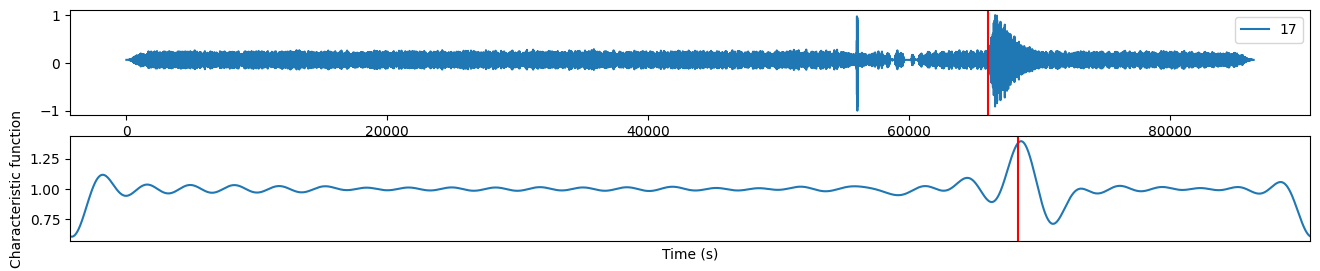

In [49]:
#main Inspeccion individual de señales sospechosas PAPA
i=17
fig,ax = plt.subplots(2,1,figsize=(16,3))
tr_times, tr_data_filt_norm, arrival_time_rel , df= data_extrac(i)
cft = CFT(tr_data_filt_norm, df)
filter_cft = test(cft)

# Plot characteristic function

ax[1].plot(tr_times,filter_cft)

ax[1].set_xticks([])
ax[1].axvline(x = arrival_time_rel, color='red',label='Rel. Arrival')
ax[1].set_xlim([min(tr_times),max(tr_times)])

#ax[1].set_xlim([72000,76000])
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Characteristic function')

#plot RAW signal
ax[0].plot(tr_times,tr_data_filt_norm, label = f'{i}')
ax[0].axvline(x = arrival_time_rel, color='red')        #,label='Rel. Arrival')
ax[0].legend()

Arreglo original: [0.         0.         0.         ... 0.96571669 0.96567291 0.96565447]
Arreglo filtrado: [0.06296113 0.06299117 0.06302131 ... 0.06287164 0.06290137 0.0629312 ]


Text(0, 0.5, 'Characteristic function')

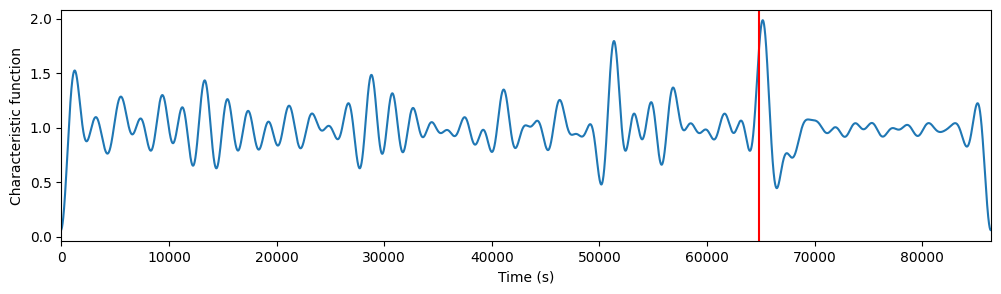

In [28]:
# Número de puntos en el arreglo
n = len(cft)

# Frecuencia de muestreo (ajusta según tu contexto)
sampling_rate = 1.0  # Puedes cambiar este valor dependiendo de tu señal

# Realizar la FFT del arreglo
cft_fft = fft(cft)

# Crear las frecuencias correspondientes para cada componente
frequencies = fftfreq(n, d=sampling_rate)

# Definir las frecuencias de corte del filtro pasa banda (bandpass)
low_cutoff = 0  # Frecuencia de corte inferior
high_cutoff = 0.00009  # Frecuencia de corte superior

# Aplicar el filtro pasa banda: mantener solo las frecuencias entre low_cutoff y high_cutoff
cft_fft[(np.abs(frequencies) < low_cutoff) | (np.abs(frequencies) > high_cutoff)] = 0

# Realizar la inversa de la FFT para regresar al dominio temporal
filtered_cft = ifft(cft_fft)

# Obtener la parte real del arreglo filtrado, ya que ifft devuelve números complejos
filtered_cft_real = np.real(filtered_cft)

# Mostrar el arreglo original y el filtrado
print("Arreglo original:", cft)
print("Arreglo filtrado:", filtered_cft_real)

# Plot characteristic function
fig,ax = plt.subplots(1,1,figsize=(12,3))
ax.plot(tr_times,filtered_cft_real)
ax.set_xlim([min(tr_times),max(tr_times)])
ax.axvline(x = arrival, color='red',label='Rel. Arrival')
#ax.set_xlim([72000,76000])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Characteristic function')

### COLLECTION OF TRAINING DATA

In [23]:

NumSamples = cat.shape[0]
samples_cft = []
samples_cft_fft = []
arrivals = []

index = np.arange(0, 76, 1)
#index = np.array([10,11])
for i in index:    
    row = cat.iloc[i]
    arrival_time = datetime.strptime(row['time_abs(%Y-%m-%dT%H:%M:%S.%f)'],'%Y-%m-%dT%H:%M:%S.%f')
    #print(arrival_time)

    #print(row)

    # If we want the value of relative time, we don't need to use datetime
    arrival_time_rel = row['time_rel(sec)']
    #print(arrival_time_rel)

    # Let's also get the name of the file
    test_filename = row.filename
    #print(test_filename)

    data_directory = './data/lunar/training/data/S12_GradeA/'
    mseed_file = f'{data_directory}{test_filename}.mseed'
    st = read(mseed_file)
    #print(st)
    # The stream file also contains some useful header information
    #print(st[0].stats)

    # This is how you get the data and the time, which is in seconds
    tr = st.traces[0].copy()
    tr_times = tr.times()
    tr_data = tr.data

    # Start time of trace (another way to get the relative arrival time using datetime)
    starttime = tr.stats.starttime.datetime
    arrival = (arrival_time - starttime).total_seconds()
    #print(arrival)

    ### FILTEERR

    # Set the minimum frequency
    # minfreq = 0.5
    # maxfreq = 1.0
    minfreq = 0.5
    maxfreq = 1.0

    # Going to create a separate trace for the filter data
    st_filt = st.copy()
    st_filt.filter('bandpass',freqmin=minfreq,freqmax=maxfreq)
    tr_filt = st_filt.traces[0].copy()
    tr_times_filt = tr_filt.times()
    tr_data_filt = tr_filt.data

    ### NORMALIZATIOONN

    # Normalize [-1, 1]
    # Reshape array to use MinMaxScaler
    tr_data_filt_norm = tr_data_filt.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(-1, 1))
    tr_data_filt_norm = scaler.fit_transform(tr_data_filt_norm)

    ### CFT

    # Sampling frequency of our trace
    df = tr.stats.sampling_rate

    # How long should the short-term and long-term window be, in seconds?\
    sta_len = 120
    lta_len = 600
    # sta_len = 1000
    # lta_len = 2000

    # Run Obspy's STA/LTA to obtain a characteristic function
    # This function basically calculates the ratio of amplitude between the short-term 
    # and long-term windows, moving consecutively in time across the data
    #cft = classic_sta_lta(tr_data, int(sta_len * df), int(lta_len * df))
    tr_data_filt_norm = tr_data_filt_norm.reshape(-1)
    cft = classic_sta_lta(tr_data_filt_norm, int(sta_len * df), int(lta_len * df))
    

    # print(tr_times, np.shape(tr_times))
    # print(cft, np.shape(cft))
    # print(arrival)

    diff = np.abs(tr_times - arrival)
    index_arrival = np.argmin(diff)

    samples_cft.append(cft)
    arrivals.append(index_arrival)

    ### FFT

    # Número de puntos en el arreglo
    n = len(cft)

    # Frecuencia de muestreo (puedes ajustarla dependiendo del contexto)
    sampling_rate = 1.0  # Ajusta según corresponda

    # Realizar la FFT del arreglo
    cft_fft = fft(cft)

    # Crear las frecuencias correspondientes
    frequencies = fftfreq(n, d=sampling_rate)

    # Definir la frecuencia de corte para el filtro
    cutoff_freq = 0.0001/1 # Ajusta según lo que necesites

    # Aplicar el filtro pasa bajos: eliminar las frecuencias más altas que la frecuencia de corte
    cft_fft[np.abs(frequencies) > cutoff_freq] = 0

    # Realizar la inversa de la FFT para regresar al dominio temporal
    filtered_cft = ifft(cft_fft)

    # La señal filtrada está en dominio temporal (real)
    filtered_cft_real = np.real(filtered_cft)

    samples_cft_fft.append(filtered_cft_real)    


# Encontrar la dimensión máxima
maxdim = max(len(sample) for sample in samples_cft)

# Crear una matriz rellena de ceros de tamaño (5, max_dim)
X_train1 = np.zeros((len(samples_cft), maxdim))
X_train2 = np.zeros((len(samples_cft), maxdim))

# Rellenar la matriz con los arreglos
for i, sample in enumerate(samples_cft):
    X_train1[i, :len(sample)] = sample

for i, sample in enumerate(samples_cft_fft):
    X_train2[i, :len(sample)] = sample

Y_train = arrivals



In [24]:
print(X_train1, np.shape(X_train1))
print(X_train2, np.shape(X_train2))

print(arrivals, np.shape(arrivals))
print(Y_train, np.shape(Y_train))

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] (76, 572427)
[[0.04901541 0.04896658 0.04891786 ... 0.         0.         0.        ]
 [0.02744579 0.02756929 0.0276929  ... 0.         0.         0.        ]
 [0.4061101  0.4059866  0.40586315 ... 0.         0.         0.        ]
 ...
 [0.42616951 0.42603209 0.42589472 ... 0.         0.         0.        ]
 [0.19450044 0.19429103 0.19408174 ... 0.         0.         0.        ]
 [0.39166325 0.39152528 0.39138739 ... 0.         0.         0.        ]] (76, 572427)
[np.int64(486933), np.int64(84267), np.int64(483754), np.int64(29414), np.int64(345423), np.int64(453147), np.int64(477397), np.int64(121632), np.int64(279837), np.int64(475807), np.int64(274669), np.int64(306070), np.int64(175693), np.int64(490512), np.int64(374045), np.int64(302098), np.int64(357351), np.int64(437646), np.int64(88244), np.int64(364904), np.int64(243343)

Text(0, 0.5, 'Characteristic function')

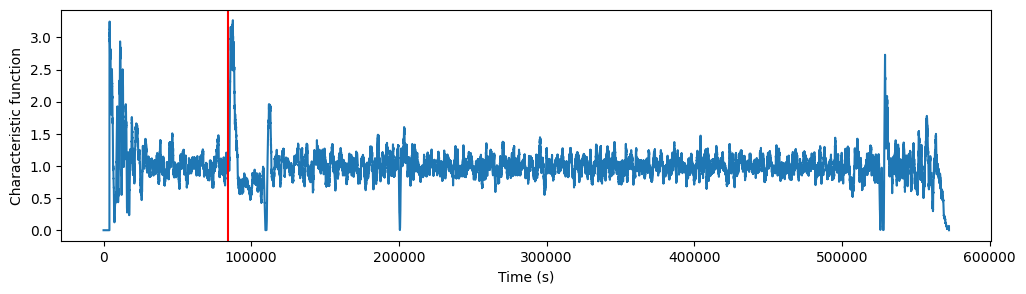

In [28]:
# Plot characteristic function
fig,ax = plt.subplots(1,1,figsize=(12,3))
ax.plot(X_train1[1])
#ax.set_xlim([min(tr_times),max(tr_times)])
#ax.set_xlim([72000,76000])
ax.set_xlabel('Time (s)')
ax.axvline(x = Y_train[1], color='red',label='Rel. Arrival')
ax.set_ylabel('Characteristic function')

Text(0, 0.5, 'Characteristic function')

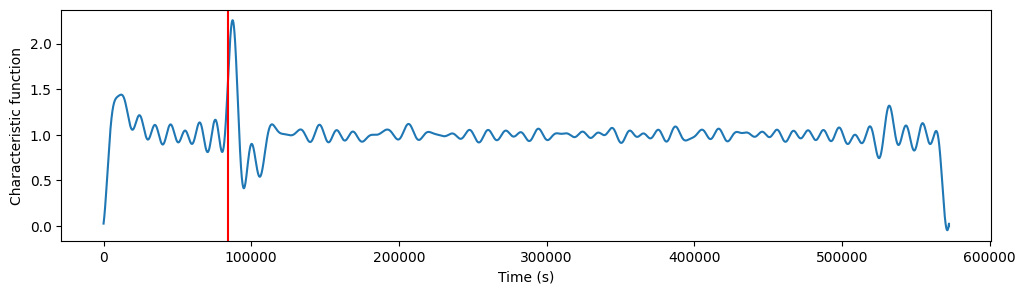

In [29]:
# Plot characteristic function
fig,ax = plt.subplots(1,1,figsize=(12,3))
ax.plot(X_train2[1])
#ax.set_xlim([min(tr_times),max(tr_times)])
#ax.set_xlim([72000,76000])
ax.set_xlabel('Time (s)')
ax.axvline(x = Y_train[1], color='red',label='Rel. Arrival')
ax.set_ylabel('Characteristic function')

#Pruebeas random

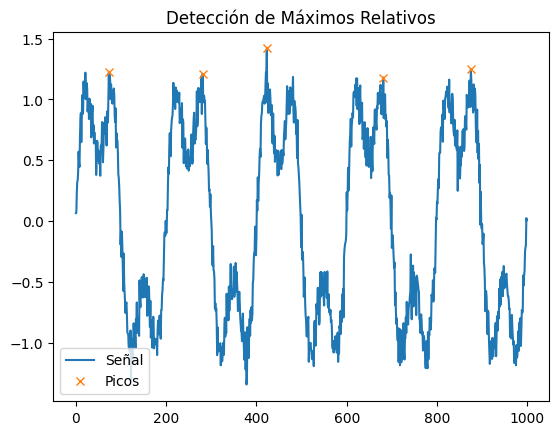

Picos encontrados en los índices: [ 73 281 423 681 875]


In [52]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Crear una señal de ejemplo (puedes reemplazarla con tu propia señal)
x = np.linspace(0, 10 * np.pi, 1000)
señal = np.sin(x) + 0.5 * np.sin(3 * x) + 0.1 * np.random.randn(1000)

# Usar find_peaks para detectar los máximos relativos con un parámetro de prominencia
peaks, properties = find_peaks(señal, prominence=0.5, distance=50)

# Gráfico de la señal con los picos encontrados
plt.plot(señal, label="Señal")
plt.plot(peaks, señal[peaks], "x", label="Picos")
plt.title("Detección de Máximos Relativos")
plt.legend()
plt.show()

# Mostrar los índices de los picos encontrados
print(f"Picos encontrados en los índices: {peaks}")


In [54]:
# Especificar el directorio que quieres recorrer
directorio = './data/lunar/test/data/S12_GradeB/'

# Lista para almacenar los nombres de los archivos
nombres_archivos = []

# Recorrer todos los archivos en el directorio
for nombre_archivo in os.listdir(directorio):
    # Comprobar si es un archivo (y no una carpeta)
    if os.path.isfile(os.path.join(directorio, nombre_archivo)) and nombre_archivo.endswith('.mseed'):
        nombres_archivos.append(nombre_archivo)

# Mostrar los nombres de los archivos
print(nombres_archivos)

['xa.s12.00.mhz.1969-12-16HR00_evid00006.mseed', 'xa.s12.00.mhz.1970-01-09HR00_evid00007.mseed', 'xa.s12.00.mhz.1970-02-07HR00_evid00014.mseed', 'xa.s12.00.mhz.1970-02-18HR00_evid00016.mseed', 'xa.s12.00.mhz.1970-03-14HR00_evid00018.mseed', 'xa.s12.00.mhz.1970-03-30HR00_evid00020.mseed', 'xa.s12.00.mhz.1970-04-03HR00_evid00021.mseed', 'xa.s12.00.mhz.1970-05-20HR00_evid00026.mseed', 'xa.s12.00.mhz.1970-05-23HR00_evid00027.mseed', 'xa.s12.00.mhz.1970-05-24HR00_evid00028.mseed', 'xa.s12.00.mhz.1970-05-25HR00_evid00029.mseed', 'xa.s12.00.mhz.1970-06-19HR00_evid00031.mseed', 'xa.s12.00.mhz.1970-07-17HR00_evid00035.mseed', 'xa.s12.00.mhz.1970-07-18HR00_evid00036.mseed', 'xa.s12.00.mhz.1970-07-20HR00_evid00037.mseed', 'xa.s12.00.mhz.1970-07-27HR00_evid00039.mseed', 'xa.s12.00.mhz.1970-09-09HR00_evid00043.mseed', 'xa.s12.00.mhz.1970-10-26HR00_evid00049.mseed', 'xa.s12.00.mhz.1970-11-03HR00_evid00050.mseed', 'xa.s12.00.mhz.1970-11-03HR00_evid00051.mseed', 'xa.s12.00.mhz.1971-01-03HR00_evid00057